### Project N_3
# Analysis of user's behavior


### The purpose of research:
### To trace the influence of onboarding on the behavior of users of the Quiz Freeze game. 

- To determine whether the time of passing different stages differs between users who have completed training and users who have not started training.
- To find out if there is any relation between the probability of payment and the number of training sessions that the user started or completed.
- To find out how often users start training after they have chosen the level of difficulty of training.

Tasks:

1. Determine how much training reduces the time of passing the stages of the game.
2. To prove that successful training in itself affects the payment and it does not matter what stage it passed through.
3. Check how transparent the process of interacting with the game is.

The project is based on data on the users of the game who registered during 2018

### 0. Reading and preparing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

events_df=pd.read_csv('data/7_4_Events.csv')
# Converting the date to the format to_datetime, the data with the error is changed to NaN:
events_df['start_time']=pd.to_datetime(events_df['start_time'],errors='coerce',dayfirst=False) 

In [2]:
# Filtering out the rows with the event "registration" in 2018:
mask1=(events_df['start_time']>='2018-01-01')&(events_df['start_time']<'2019-01-01')&(events_df['event_type']=='registration')

# From the previous data frame, we extract it into a separate list user_id:
user_list=list(events_df[mask1]['user_id'])

# Filter out the main data frame in such a way that only users from the list created above, that is, registered in 2018, appear in it:
events_df=events_df[events_df['user_id'].isin(user_list)]
events_df

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836
...,...,...,...,...,...,...
118359,147262,tutorial_start,NaN,2019-01-01 03:26:18,49554.0,47756
118360,147263,tutorial_finish,NaN,2019-01-01 03:29:25,49554.0,47756
118362,147265,level_choice,easy,2019-01-01 05:04:52,NaN,47755
118363,147266,level_choice,medium,2019-01-01 05:42:11,NaN,47756


In [3]:
purchase_df=pd.read_csv('data/7_4_Purchase.csv')
purchase_df['event_datetime']=pd.to_datetime(purchase_df['event_datetime'],dayfirst=False)

# In the same way, filter out the main data frame with purchases so that only users registered in 2018 will be in it 
purchase_df=purchase_df[purchase_df['user_id'].isin(user_list)] 
purchase_df

,id,user_id,event_datetime,amount
1171,16845,27845,2018-01-03 18:53:43,100
1172,16846,27865,2018-01-04 14:46:10,250
1174,16848,27911,2018-01-07 08:19:12,50
1175,16849,27910,2018-01-07 12:11:34,100
1176,16850,27940,2018-01-07 13:16:41,200
...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100
2768,18442,47647,2019-01-02 23:26:26,150
2769,18443,47554,2019-01-03 00:36:36,50
2774,18448,47742,2019-01-04 12:51:41,50


### 1. Determine how much training reduces the time of passing the stages of the game.

In [4]:
# Creating a new attribute with a data frame with purchases - 
# "event type" and the value for it "purchase":
purchase_df['event_type'] = 'purchase'
# Renaming columns in dataframes to merge them 
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})
# Combining two data frames into one 
total_events_df = pd.concat([events_df,purchase_df],sort=False)
# Update the indexes and sort the data by the time of event registration 
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [5]:
# Creating a list of users who have started training at least once 
mask2=total_events_df['event_type'] == 'tutorial_start'
started_tutorial_users=list(total_events_df[mask2]['user_id'])

# Creating a list of users who have completed training at least once 
mask3=total_events_df['event_type'] == 'tutorial_finish'
finished_tutorial_users=list(total_events_df[mask3]['user_id'])

# Creating a dataframe for users who have started training at least once 
started_df=total_events_df[total_events_df['user_id'].isin(started_tutorial_users)]
started_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [6]:
# Creating a data frame for users who have completed training at least once 
finished_df=total_events_df[total_events_df['user_id'].isin(finished_tutorial_users)]
finished_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [7]:
# Creating a data frame for users who have never started training 
no_tutorial_df=total_events_df[~total_events_df['user_id'].isin(started_tutorial_users)]
no_tutorial_df['user_id'].nunique()

8068

In [8]:
print('Total number of users:', total_events_df['user_id'].nunique(), '\n'
    'The number of users who have started training at least once:', started_df['user_id'].nunique(), '\n'
      'The number of users who have completed training at least once:', finished_df['user_id'].nunique(), '\n'
      'The number of users who have never started training:', no_tutorial_df['user_id'].nunique())

Total number of users: 19926 
The number of users who have started training at least once: 11858 
The number of users who have completed training at least once: 10250 
The number of users who have never started training: 8068


#### a) Users who have started training at least once

In [9]:
# For each group, create data frames separately for each event to combine them and calculate the average time between events
# Registration of users who have started training at least once
registration_df = started_df[started_df['event_type']=='registration']
# Rename the start_time column to registration_time for further merge
registration_df = registration_df.rename(columns={'start_time':'registration_time'})
registration_df

,event_id,event_type,selected_level,registration_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
14,80322.0,registration,NaN,2018-01-01 18:24:01,NaN,27839,NaN,NaN
...,...,...,...,...,...,...,...,...
66919,147227.0,registration,NaN,2018-12-31 03:29:04,NaN,47748,NaN,NaN
66939,147247.0,registration,NaN,2018-12-31 13:55:01,NaN,47751,NaN,NaN
66941,147249.0,registration,NaN,2018-12-31 18:58:55,NaN,47753,NaN,NaN
66947,147255.0,registration,NaN,2018-12-31 21:15:14,NaN,47755,NaN,NaN


In [10]:
# Start of training
tutorial_df = started_df[started_df['event_type']=='tutorial_start']
tutorial_df = tutorial_df.rename(columns={'start_time':'tutorial_start_time'})
tutorial_df 

,event_id,event_type,selected_level,tutorial_start_time,tutorial_id,user_id,purchase_id,amount
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
8,80316.0,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN,NaN
10,80318.0,tutorial_start,NaN,2018-01-01 15:40:43,31507.0,27836,NaN,NaN
12,80320.0,tutorial_start,NaN,2018-01-01 17:47:40,31508.0,27833,NaN,NaN
15,80323.0,tutorial_start,NaN,2018-01-01 19:11:36,31509.0,27839,NaN,NaN
...,...,...,...,...,...,...,...,...
66934,147242.0,tutorial_start,NaN,2018-12-31 10:21:11,49550.0,47747,NaN,NaN
66943,147251.0,tutorial_start,NaN,2018-12-31 19:38:14,49551.0,47751,NaN,NaN
66945,147253.0,tutorial_start,NaN,2018-12-31 20:54:56,49552.0,47753,NaN,NaN
66952,147260.0,tutorial_start,NaN,2019-01-01 00:08:14,49553.0,47755,NaN,NaN


In [11]:
# Finish of training
finish_tutorial_df = started_df[started_df['event_type']=='tutorial_finish']
finish_tutorial_df = finish_tutorial_df.rename(columns={'start_time':'finish_time'})
finish_tutorial_df

,event_id,event_type,selected_level,finish_time,tutorial_id,user_id,purchase_id,amount
9,80317.0,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN,NaN
11,80319.0,tutorial_finish,NaN,2018-01-01 15:42:58,31507.0,27836,NaN,NaN
13,80321.0,tutorial_finish,NaN,2018-01-01 17:50:08,31508.0,27833,NaN,NaN
16,80324.0,tutorial_finish,NaN,2018-01-01 19:16:32,31509.0,27839,NaN,NaN
18,80326.0,tutorial_finish,NaN,2018-01-01 19:48:01,31510.0,27834,NaN,NaN
...,...,...,...,...,...,...,...,...
66935,147243.0,tutorial_finish,NaN,2018-12-31 10:22:45,49550.0,47747,NaN,NaN
66944,147252.0,tutorial_finish,NaN,2018-12-31 19:39:34,49551.0,47751,NaN,NaN
66946,147254.0,tutorial_finish,NaN,2018-12-31 20:57:07,49552.0,47753,NaN,NaN
66953,147261.0,tutorial_finish,NaN,2019-01-01 00:09:30,49553.0,47755,NaN,NaN


In [12]:
# Choosing the level
level_df = started_df[started_df['event_type']=='level_choice']
level_df = level_df.rename(columns={'start_time':'level_time'})
level_df

,event_id,event_type,selected_level,level_time,tutorial_id,user_id,purchase_id,amount
19,80327.0,level_choice,medium,2018-01-01 20:37:22,NaN,27835,NaN,NaN
23,80331.0,level_choice,hard,2018-01-01 22:37:50,NaN,27839,NaN,NaN
36,80344.0,level_choice,medium,2018-01-02 05:18:42,NaN,27840,NaN,NaN
38,80346.0,level_choice,hard,2018-01-02 06:19:18,NaN,27845,NaN,NaN
45,80353.0,level_choice,easy,2018-01-02 08:46:03,NaN,27842,NaN,NaN
...,...,...,...,...,...,...,...,...
66932,147240.0,level_choice,medium,2018-12-31 09:59:00,NaN,47732,NaN,NaN
66937,147245.0,level_choice,medium,2018-12-31 12:24:40,NaN,47747,NaN,NaN
66948,147256.0,level_choice,medium,2018-12-31 22:36:19,NaN,47753,NaN,NaN
66956,147265.0,level_choice,easy,2019-01-01 05:04:52,NaN,47755,NaN,NaN


In [13]:
# Choosing question packages
pack_df = started_df[started_df['event_type']=='pack_choice']
pack_df = pack_df.rename(columns={'start_time':'pack_time'})
pack_df

,event_id,event_type,selected_level,pack_time,tutorial_id,user_id,purchase_id,amount
20,80328.0,pack_choice,NaN,2018-01-01 20:38:43,NaN,27835,NaN,NaN
24,80332.0,pack_choice,NaN,2018-01-01 22:42:54,NaN,27839,NaN,NaN
39,80347.0,pack_choice,NaN,2018-01-02 06:25:12,NaN,27845,NaN,NaN
53,80361.0,pack_choice,NaN,2018-01-02 11:59:26,NaN,27849,NaN,NaN
58,80366.0,pack_choice,NaN,2018-01-02 14:14:51,NaN,27843,NaN,NaN
...,...,...,...,...,...,...,...,...
66923,147231.0,pack_choice,NaN,2018-12-31 05:06:10,NaN,47742,NaN,NaN
66931,147239.0,pack_choice,NaN,2018-12-31 07:59:18,NaN,47744,NaN,NaN
66933,147241.0,pack_choice,NaN,2018-12-31 10:05:18,NaN,47732,NaN,NaN
66949,147257.0,pack_choice,NaN,2018-12-31 22:38:05,NaN,47753,NaN,NaN


In [14]:
# Purchase of paid question packages
purchase_df = started_df[started_df['event_type']=='purchase']
purchase_df = purchase_df.rename(columns={'start_time':'purchase_time'})
purchase_df

,event_id,event_type,selected_level,purchase_time,tutorial_id,user_id,purchase_id,amount
66959,NaN,purchase,NaN,2018-01-03 18:53:43,NaN,27845,16845.0,100.0
66960,NaN,purchase,NaN,2018-01-04 14:46:10,NaN,27865,16846.0,250.0
66961,NaN,purchase,NaN,2018-01-07 08:19:12,NaN,27911,16848.0,50.0
66962,NaN,purchase,NaN,2018-01-07 12:11:34,NaN,27910,16849.0,100.0
66963,NaN,purchase,NaN,2018-01-07 13:16:41,NaN,27940,16850.0,200.0
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [15]:
# Merge datasets into one
# Creating a dataset by adding events to it one at a time and removing unnecessary columns
# Attach the level selection on the right data frame to the registrations, 
# since it does not make sense to consider users who have not switched to the level selection
event_times_df = registration_df.merge(level_df,on='user_id',how='right')
event_times_df = event_times_df.drop(
    columns=['event_id_x','selected_level_x','tutorial_id_x','purchase_id_x','amount_x','event_id_y','tutorial_id_y','purchase_id_y','amount_y']
    )
event_times_df

,event_type_x,registration_time,user_id,event_type_y,selected_level_y,level_time
0,registration,2018-01-01 11:54:47,27835,level_choice,medium,2018-01-01 20:37:22
1,registration,2018-01-01 18:24:01,27839,level_choice,hard,2018-01-01 22:37:50
2,registration,2018-01-01 20:53:21,27840,level_choice,medium,2018-01-02 05:18:42
3,registration,2018-01-02 01:35:56,27845,level_choice,hard,2018-01-02 06:19:18
4,registration,2018-01-01 23:18:46,27842,level_choice,easy,2018-01-02 08:46:03
...,...,...,...,...,...,...
8239,registration,2018-12-30 14:20:21,47732,level_choice,medium,2018-12-31 09:59:00
8240,registration,2018-12-31 03:01:17,47747,level_choice,medium,2018-12-31 12:24:40
8241,registration,2018-12-31 18:58:55,47753,level_choice,medium,2018-12-31 22:36:19
8242,registration,2018-12-31 21:15:14,47755,level_choice,easy,2019-01-01 05:04:52


In [16]:
# Next, add datasets
event_times_df = event_times_df.merge(pack_df,on='user_id',how='left',suffixes=('_z', '_i'))
event_times_df = event_times_df.drop(
    columns=['selected_level','purchase_id','event_id','tutorial_id','amount']
    )
event_times_df

,event_type_x,registration_time,user_id,event_type_y,selected_level_y,level_time,event_type,pack_time
0,registration,2018-01-01 11:54:47,27835,level_choice,medium,2018-01-01 20:37:22,pack_choice,2018-01-01 20:38:43
1,registration,2018-01-01 18:24:01,27839,level_choice,hard,2018-01-01 22:37:50,pack_choice,2018-01-01 22:42:54
2,registration,2018-01-01 20:53:21,27840,level_choice,medium,2018-01-02 05:18:42,NaN,NaT
3,registration,2018-01-02 01:35:56,27845,level_choice,hard,2018-01-02 06:19:18,pack_choice,2018-01-02 06:25:12
4,registration,2018-01-01 23:18:46,27842,level_choice,easy,2018-01-02 08:46:03,NaN,NaT
...,...,...,...,...,...,...,...,...
8239,registration,2018-12-30 14:20:21,47732,level_choice,medium,2018-12-31 09:59:00,pack_choice,2018-12-31 10:05:18
8240,registration,2018-12-31 03:01:17,47747,level_choice,medium,2018-12-31 12:24:40,NaN,NaT
8241,registration,2018-12-31 18:58:55,47753,level_choice,medium,2018-12-31 22:36:19,pack_choice,2018-12-31 22:38:05
8242,registration,2018-12-31 21:15:14,47755,level_choice,easy,2019-01-01 05:04:52,NaN,NaT


In [17]:
event_times_df = event_times_df.merge(purchase_df,on='user_id',how='left',suffixes=('_3', '_4'))
event_times_df = event_times_df.drop(
    columns=['event_id','selected_level','tutorial_id','purchase_id']
    )
# Check the correctness of the data: the number of non-zero values in the columns with events corresponds to the number of records 
# in the corresponding event data frame
event_times_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8244 entries, 0 to 8243
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   event_type_x       8244 non-null   object        
 1   registration_time  8244 non-null   datetime64[ns]
 2   user_id            8244 non-null   int64         
 3   event_type_y       8244 non-null   object        
 4   selected_level_y   8244 non-null   object        
 5   level_time         8244 non-null   datetime64[ns]
 6   event_type_3       5663 non-null   object        
 7   pack_time          5663 non-null   datetime64[ns]
 8   event_type_4       1578 non-null   object        
 9   purchase_time      1578 non-null   datetime64[ns]
 10  amount             1578 non-null   float64       
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 708.6+ KB


In [18]:
# Calculating the time intervals between events
event_times_df['delta_registration_level']=event_times_df['level_time']-event_times_df['registration_time']
event_times_df['delta_level_pack']=event_times_df['pack_time']-event_times_df['level_time']
event_times_df['delta_pack_purchase']=event_times_df['purchase_time']-event_times_df['pack_time']
event_times_df['delta_registration_purchase']=event_times_df['purchase_time']-event_times_df['registration_time']
event_times_df.describe()

,registration_time,user_id,level_time,pack_time,purchase_time,amount,delta_registration_level,delta_level_pack,delta_pack_purchase,delta_registration_purchase
count,8244,8244.000000,8244,5663,1578,1578.000000,8244,5663,1578,1578
mean,2018-07-04 01:29:06.233988096,37832.572659,2018-07-04 08:40:47.261280768,2018-07-04 23:10:20.535581696,2018-07-06 08:38:25.337769472,110.487959,0 days 07:11:41.027292576,0 days 00:05:17.040967684,3 days 17:37:39.078580481,4 days 00:55:11.653992395
min,2018-01-01 11:54:47,27835.000000,2018-01-01 20:37:22,2018-01-01 20:38:43,2018-01-03 18:53:43,25.000000,0 days 00:08:15,0 days 00:00:19,0 days 00:44:50,0 days 04:36:58
25%,2018-03-24 15:52:06.750000128,32879.500000,2018-03-24 23:26:06.500000,2018-03-25 14:55:49,2018-03-27 17:36:18.750000128,50.000000,0 days 03:54:28.750000,0 days 00:03:05,1 days 21:21:47.750000,2 days 04:24:46.750000
50%,2018-06-23 20:01:43.500000,37755.000000,2018-06-24 02:51:24.500000,2018-06-26 20:53:44,2018-06-26 04:43:38.500000,100.000000,0 days 06:04:06.500000,0 days 00:04:57,3 days 12:45:06,3 days 19:36:08.500000
75%,2018-10-14 14:36:15,42873.250000,2018-10-14 22:45:34.500000,2018-10-15 18:55:23,2018-10-21 03:44:59,150.000000,0 days 09:36:09,0 days 00:07:07,5 days 09:38:37.750000,5 days 16:41:40.500000
max,2018-12-31 23:17:30,47756.000000,2019-01-01 05:42:11,2019-01-01 05:50:36,2019-01-06 07:14:25,300.000000,1 days 18:48:25,0 days 00:15:48,10 days 18:33:59,11 days 00:35:04
std,NaN,5773.035513,NaN,NaN,NaN,54.419018,0 days 04:34:08.503616882,0 days 00:02:43.700703288,2 days 04:37:04.160337559,2 days 04:50:06.596995302


#### b) Users who have completed the training at least once

In [19]:
# Registration of users who have completed training at least once
registration_df2 = finished_df[finished_df['event_type']=='registration']
# Rename the start_time column to registration_time for further merge
registration_df2 = registration_df2.rename(columns={'start_time':'registration_time'})

# Start of training
tutorial_df2 = finished_df[finished_df['event_type']=='tutorial_start']
tutorial_df2 = tutorial_df2.rename(columns={'start_time':'tutorial_start_time'})

# End of training
finish_tutorial_df2 = finished_df[finished_df['event_type']=='tutorial_finish']
finish_tutorial_df2 = finish_tutorial_df2.rename(columns={'start_time':'finish_time'})

# Choosing the level
level_df2 = finished_df[finished_df['event_type']=='level_choice']
level_df2 = level_df2.rename(columns={'start_time':'level_time'})

# Choosing question packages
pack_df2 = finished_df[finished_df['event_type']=='pack_choice']
pack_df2 = pack_df2.rename(columns={'start_time':'pack_time'})

# Purchase of paid question packages
purchase_df2 = finished_df[finished_df['event_type']=='purchase']
purchase_df2 = purchase_df2.rename(columns={'start_time':'purchase_time'})

event_times_df2 = registration_df2.merge(level_df2,on='user_id',how='right')
event_times_df2 = event_times_df2.drop(
    columns=['event_id_x','selected_level_x','tutorial_id_x','purchase_id_x','amount_x','event_id_y','tutorial_id_y','purchase_id_y','amount_y']
    )

event_times_df2 = event_times_df2.merge(pack_df2,on='user_id',how='left',suffixes=('_z', '_i'))
event_times_df2 = event_times_df2.drop(
    columns=['selected_level','purchase_id','event_id','tutorial_id','amount']
    )

event_times_df2 = event_times_df2.merge(purchase_df2,on='user_id',how='left',suffixes=('_3', '_4'))
event_times_df2 = event_times_df2.drop(
    columns=['event_id','selected_level','tutorial_id','purchase_id']
    )
# Checking the correctness of the data
event_times_df2.info()

# Calculate the time intervals between events
event_times_df2['delta_registration_level']=event_times_df2['level_time']-event_times_df2['registration_time']
event_times_df2['delta_level_pack']=event_times_df2['pack_time']-event_times_df2['level_time']
event_times_df2['delta_pack_purchase']=event_times_df2['purchase_time']-event_times_df2['pack_time']
event_times_df2['delta_registration_purchase']=event_times_df2['purchase_time']-event_times_df2['registration_time']
event_times_df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   event_type_x       7501 non-null   object        
 1   registration_time  7501 non-null   datetime64[ns]
 2   user_id            7501 non-null   int64         
 3   event_type_y       7501 non-null   object        
 4   selected_level_y   7501 non-null   object        
 5   level_time         7501 non-null   datetime64[ns]
 6   event_type_3       5176 non-null   object        
 7   pack_time          5176 non-null   datetime64[ns]
 8   event_type_4       1447 non-null   object        
 9   purchase_time      1447 non-null   datetime64[ns]
 10  amount             1447 non-null   float64       
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 644.7+ KB


,registration_time,user_id,level_time,pack_time,purchase_time,amount,delta_registration_level,delta_level_pack,delta_pack_purchase,delta_registration_purchase
count,7501,7501.000000,7501,5176,1447,1447.000000,7501,5176,1447,1447
mean,2018-07-03 20:56:47.816424448,37822.983202,2018-07-04 04:02:24.671243776,2018-07-04 18:49:00.088098816,2018-07-05 19:13:35.193503744,110.988252,0 days 07:05:36.854819357,0 days 00:05:18.146058732,3 days 17:17:59.641326883,4 days 00:30:03.247408431
min,2018-01-01 11:54:47,27835.000000,2018-01-01 20:37:22,2018-01-01 20:38:43,2018-01-03 18:53:43,25.000000,0 days 00:08:15,0 days 00:00:19,0 days 00:44:50,0 days 04:36:58
25%,2018-03-24 08:41:42,32850.000000,2018-03-24 13:47:36,2018-03-25 02:24:08.500000,2018-03-27 14:29:37,50.000000,0 days 03:51:41,0 days 00:03:05,1 days 21:16:05.500000,2 days 04:09:55
50%,2018-06-23 15:04:17,37707.000000,2018-06-23 20:18:59,2018-06-25 20:19:02.500000,2018-06-25 22:56:25,100.000000,0 days 06:00:07,0 days 00:04:58,3 days 12:15:56,3 days 19:04:59
75%,2018-10-13 20:22:32,42850.000000,2018-10-14 04:29:37,2018-10-15 17:27:23,2018-10-19 18:35:42.500000,150.000000,0 days 09:25:42,0 days 00:07:11,5 days 08:53:44.500000,5 days 15:46:14
max,2018-12-31 23:17:30,47756.000000,2019-01-01 05:42:11,2019-01-01 05:50:36,2019-01-06 07:14:25,300.000000,1 days 18:48:25,0 days 00:15:48,10 days 18:33:59,11 days 00:35:04
std,NaN,5773.271851,NaN,NaN,NaN,54.565344,0 days 04:30:23.231509186,0 days 00:02:44.449118501,2 days 04:31:59.804658578,2 days 04:47:29.946150698


#### c) Users who have never started training

In [20]:
# Registration of users who have never started training
registration_df3 = no_tutorial_df[no_tutorial_df['event_type']=='registration']
# Rename the start_time column to registration_time for further merge
registration_df3 = registration_df3.rename(columns={'start_time':'registration_time'})
registration_df3

,event_id,event_type,selected_level,registration_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
27,80335.0,registration,NaN,2018-01-02 00:13:22,NaN,27844,NaN,NaN
37,80345.0,registration,NaN,2018-01-02 06:05:02,NaN,27848,NaN,NaN
...,...,...,...,...,...,...,...,...
66936,147244.0,registration,NaN,2018-12-31 12:03:59,NaN,47749,NaN,NaN
66938,147246.0,registration,NaN,2018-12-31 13:42:40,NaN,47750,NaN,NaN
66940,147248.0,registration,NaN,2018-12-31 18:49:30,NaN,47752,NaN,NaN
66942,147250.0,registration,NaN,2018-12-31 19:14:08,NaN,47754,NaN,NaN


In [21]:
# Choosing the level
level_df3 = no_tutorial_df[no_tutorial_df['event_type']=='level_choice']
level_df3 = level_df3.rename(columns={'start_time':'level_time'})

# Choosing question packages
pack_df3 = no_tutorial_df[no_tutorial_df['event_type']=='pack_choice']
pack_df3 = pack_df3.rename(columns={'start_time':'pack_time'})

# Purchase of paid question packages
purchase_df3 = no_tutorial_df[no_tutorial_df['event_type']=='purchase']
purchase_df3 = purchase_df3.rename(columns={'start_time':'purchase_time'})

In [22]:
event_times_df3 = registration_df3.merge(level_df3,on='user_id',how='left')
event_times_df3 = event_times_df3.drop(
    columns=['event_id_x','selected_level_x','tutorial_id_x','purchase_id_x','amount_x','event_id_y','tutorial_id_y','purchase_id_y','amount_y']
    )
event_times_df3

,event_type_x,registration_time,user_id,event_type_y,selected_level_y,level_time
0,registration,2018-01-01 03:48:40,27832,NaN,NaN,NaT
1,registration,2018-01-01 14:08:40,27837,NaN,NaN,NaT
2,registration,2018-01-01 14:42:58,27838,NaN,NaN,NaT
3,registration,2018-01-02 00:13:22,27844,NaN,NaN,NaT
4,registration,2018-01-02 06:05:02,27848,NaN,NaN,NaT
...,...,...,...,...,...,...
8063,registration,2018-12-31 12:03:59,47749,NaN,NaN,NaT
8064,registration,2018-12-31 13:42:40,47750,NaN,NaN,NaT
8065,registration,2018-12-31 18:49:30,47752,NaN,NaN,NaT
8066,registration,2018-12-31 19:14:08,47754,NaN,NaN,NaT


In [23]:
event_times_df3 = event_times_df3.merge(pack_df3,on='user_id',how='left',suffixes=('_z', '_i'))
event_times_df3 = event_times_df3.drop(
    columns=['selected_level','purchase_id','event_id','tutorial_id','amount']
    )

event_times_df3 = event_times_df3.merge(purchase_df3,on='user_id',how='left',suffixes=('_3', '_4'))
event_times_df3 = event_times_df3.drop(
    columns=['event_id','selected_level','tutorial_id','purchase_id']
    )
# Checking the correctness of the data
event_times_df3.info()

# Calculate the time intervals between events
event_times_df3['delta_registration_level']=event_times_df3['level_time']-event_times_df3['registration_time']
event_times_df3['delta_level_pack']=event_times_df3['pack_time']-event_times_df3['level_time']
event_times_df3['delta_pack_purchase']=event_times_df3['purchase_time']-event_times_df3['pack_time']
event_times_df3['delta_registration_purchase']=event_times_df3['purchase_time']-event_times_df3['registration_time']
event_times_df3.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   event_type_x       8068 non-null   object        
 1   registration_time  8068 non-null   datetime64[ns]
 2   user_id            8068 non-null   int64         
 3   event_type_y       98 non-null     object        
 4   selected_level_y   98 non-null     object        
 5   level_time         98 non-null     datetime64[ns]
 6   event_type_3       74 non-null     object        
 7   pack_time          74 non-null     datetime64[ns]
 8   event_type_4       22 non-null     object        
 9   purchase_time      22 non-null     datetime64[ns]
 10  amount             22 non-null     float64       
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 693.5+ KB


,registration_time,user_id,level_time,pack_time,purchase_time,amount,delta_registration_level,delta_level_pack,delta_pack_purchase,delta_registration_purchase
count,8068,8068.000000,98,74,22,22.000000,98,74,22,22
mean,2018-07-04 10:54:54.943852288,37837.681210,2018-06-28 04:20:03.397959168,2018-07-05 16:05:05.797297152,2018-07-23 03:43:36.272727296,128.409091,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090,4 days 09:06:01.909090909
min,2018-01-01 03:48:40,27832.000000,2018-01-06 01:58:40,2018-01-08 17:11:52,2018-01-16 05:08:41,25.000000,0 days 00:09:26,0 days 00:00:48,0 days 09:35:48,0 days 09:59:07
25%,2018-03-22 21:12:01.500000,32743.500000,2018-03-27 06:32:03.249999872,2018-03-28 12:17:05,2018-04-20 10:31:42.249999872,100.000000,0 days 02:15:28.500000,0 days 00:03:09.750000,2 days 15:49:22,2 days 21:31:31
50%,2018-06-27 13:52:22,37952.500000,2018-06-04 13:36:56,2018-06-23 20:41:03,2018-07-01 11:03:01,100.000000,0 days 04:56:05.500000,0 days 00:04:46.500000,4 days 04:38:42,4 days 11:29:09
75%,2018-10-13 21:54:31.500000,42854.250000,2018-10-16 10:55:37.249999872,2018-10-19 06:53:57.500000,2018-11-15 10:47:40.249999872,200.000000,0 days 08:24:01,0 days 00:07:11.250000,5 days 23:34:55.750000,6 days 02:28:47.750000
max,2018-12-31 23:18:06,47757.000000,2018-12-22 17:51:42,2018-12-22 17:59:25,2018-12-18 18:07:09,250.000000,0 days 18:34:21,0 days 00:13:32,7 days 11:56:49,7 days 16:46:20
std,NaN,5752.926151,NaN,NaN,NaN,71.253845,0 days 03:41:00.594664298,0 days 00:03:01.230146431,2 days 04:58:40.602573417,2 days 05:12:16.748091626


#### d) Combine data for all 3 user groups

In [24]:
started_level = event_times_df.delta_registration_level.mean()
finished_level = event_times_df2.delta_registration_level.mean()
no_level = event_times_df3.delta_registration_level.mean()
started_pack = event_times_df.delta_level_pack.mean()
finished_pack = event_times_df2.delta_level_pack.mean()
no_pack = event_times_df3.delta_level_pack.mean()
started_purchase = event_times_df.delta_pack_purchase.mean()
finished_purchase = event_times_df2.delta_pack_purchase.mean()
no_purchase = event_times_df3.delta_pack_purchase.mean()
started_all = event_times_df.delta_registration_purchase.mean()
finished_all = event_times_df2.delta_registration_purchase.mean()
no_all = event_times_df3.delta_registration_purchase.mean()

mean_results = pd.DataFrame({
    'tutorial_started':[started_level,started_pack,started_purchase, started_all ,],
    'tutorial_finished':[finished_level,finished_pack,finished_purchase,finished_all ],
    'no_tutorial':[no_level,no_pack,no_purchase,no_all]
},
index=['registration_level', 'level_pack', 'pack_purchase','registration_purchase']                            
)

mean_results

,tutorial_started,tutorial_finished,no_tutorial
registration_level,0 days 07:11:41.027292576,0 days 07:05:36.854819357,0 days 05:15:33.122448979
level_pack,0 days 00:05:17.040967684,0 days 00:05:18.146058732,0 days 00:05:23.824324324
pack_purchase,3 days 17:37:39.078580481,3 days 17:17:59.641326883,4 days 04:49:33.590909090
registration_purchase,4 days 00:55:11.653992395,4 days 00:30:03.247408431,4 days 09:06:01.909090909


#### e) Visualize the results

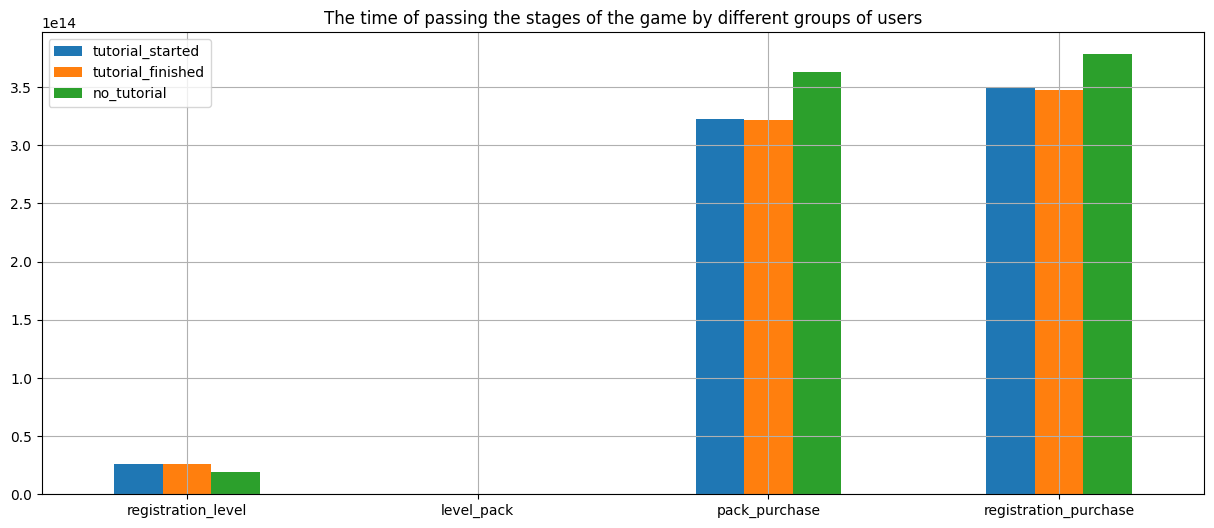

In [25]:
visual = mean_results.plot(
     kind='bar',
    grid=True,
    figsize=(15, 6)
)

visual.set_title('The time of passing the stages of the game by different groups of users')
visual.xaxis.set_tick_params(rotation=0)

***Conclusions:***
    *Training extends the average time from registration to choosing the difficulty level of the game, as it takes time in itself.
But in the meantime, it slightly reduces the time between choosing the difficulty level of the game and choosing a package of questions
and it reduces the time between choosing a package of questions and buying a paid package of questions by several hours.
On average, between registration and purchase, users who have never started training take 8 hours more time than other groups of users.
There are no significant deviations between groups of users who have completed training at least once and started, but never completed it.
Among the users who have never started training, many are churned immediately after registration. Apparently they initially did not have much interest in the game and did not go beyond registration.*

### 2. Prove that successful training in itself affects the payment and it does not matter what stage it went through.

#### a) Impact of training on the purchase

In [26]:
# Return to the data frame with users who have completed training at least once
finished_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


In [27]:
# Creating a data frame for users who have never completed training
not_finished_df=total_events_df[~total_events_df['user_id'].isin(finished_tutorial_users)]
not_finished_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
21,80329.0,registration,NaN,2018-01-01 20:53:21,NaN,27840,NaN,NaN
27,80335.0,registration,NaN,2018-01-02 00:13:22,NaN,27844,NaN,NaN
...,...,...,...,...,...,...,...,...
66936,147244.0,registration,NaN,2018-12-31 12:03:59,NaN,47749,NaN,NaN
66938,147246.0,registration,NaN,2018-12-31 13:42:40,NaN,47750,NaN,NaN
66940,147248.0,registration,NaN,2018-12-31 18:49:30,NaN,47752,NaN,NaN
66942,147250.0,registration,NaN,2018-12-31 19:14:08,NaN,47754,NaN,NaN


In [28]:
# Count the percentage of users who paid for the purchase from the total number of users:
# those who have not started training
not_started_users = no_tutorial_df['user_id'].nunique()
not_started_paid = no_tutorial_df[no_tutorial_df['event_type']=='purchase']['user_id'].nunique()
print('Percentage of users who paid for a package of questions from users who did not start training: {:.2%}'.format(not_started_paid/not_started_users))

# those who have not completed their training (it does not matter whether they started or not)
not_finished_users = not_finished_df['user_id'].nunique()
not_finished_paid = not_finished_df[not_finished_df['event_type']=='purchase']['user_id'].nunique()
print('Percentage of users who paid for a package of questions from users who did not complete the training (it does not matter whether the training was started): {:.2%}'.format(not_finished_paid/not_finished_users))

# those who started, but did not finished the training
started_users = started_df['user_id'].nunique()
started_paid = started_df[started_df['event_type']=='purchase']['user_id'].nunique()
print('Percentage of users who paid for a package of questions from users who started and did not complete training: {:.2%}'.format(started_paid/started_users))

# who started and finished the training
finished_users = finished_df['user_id'].nunique()
finished_paid = finished_df[finished_df['event_type']=='purchase']['user_id'].nunique()
print('Percentage of users who paid for a package of questions from users who started and completed training: {:.2%}'.format(finished_paid/finished_users))

Percentage of users who paid for a package of questions from users who did not start training: 0.27%
Percentage of users who paid for a package of questions from users who did not complete the training (it does not matter whether the training was started): 1.58%
Percentage of users who paid for a package of questions from users who started and did not complete training: 13.31%
Percentage of users who paid for a package of questions from users who started and completed training: 14.12%


#### b) Determining whether there is a difference at which stage the training was successful.

In [29]:
# Create functions for counting users who have started training, 
# completed it and made a purchase, apply them to the dataframe by adding the appropriate columns
def started_cnt (row):
    if row.event_type == 'tutorial_start':
        return 1

def finished_cnt (row):
    if row.event_type == 'tutorial_finish':
        return 1
    
def purch_cnt (row):
    if row.event_type == 'purchase':
        return 1
    
total_events_df['tutorials_started'] = total_events_df.apply(started_cnt, axis=1)
total_events_df['tutorials_finished'] = total_events_df.apply(finished_cnt, axis=1)
total_events_df['purchased'] = total_events_df.apply(purch_cnt, axis=1)
total_events_df['start_time'] = str(total_events_df['start_time'])
total_events_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 68559 entries, 0 to 68558
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_id            66959 non-null  float64
 1   event_type          68559 non-null  object 
 2   selected_level      8342 non-null   object 
 3   start_time          68559 non-null  object 
 4   tutorial_id         32954 non-null  float64
 5   user_id             68559 non-null  int64  
 6   purchase_id         1600 non-null   float64
 7   amount              1600 non-null   float64
 8   tutorials_started   18050 non-null  float64
 9   tutorials_finished  14904 non-null  float64
 10  purchased           1600 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 6.3+ MB


In [30]:
grouped_started = total_events_df.drop(['event_id', 'tutorial_id', 'purchase_id'], axis=1).groupby(by='user_id').sum(numeric_only=True)
grouped_started

,amount,tutorials_started,tutorials_finished,purchased
user_id,,,,
27832,0.0,0.0,0.0,0.0
27833,0.0,1.0,1.0,0.0
27834,0.0,1.0,1.0,0.0
27835,0.0,1.0,1.0,0.0
27836,0.0,2.0,1.0,0.0
...,...,...,...,...
47753,0.0,1.0,1.0,0.0
47754,0.0,0.0,0.0,0.0
47755,0.0,1.0,1.0,0.0


In [31]:
# Count users and clients
def if_user(row):
    if row.tutorials_finished > 0.0:
        return 1
    
def if_client(row):
    if row.purchased > 0.0:
        return 1    
    
grouped_started['user'] = grouped_started.apply(if_user, axis=1)
grouped_started['client'] = grouped_started.apply(if_client, axis=1)
grouped_started

,amount,tutorials_started,tutorials_finished,purchased,user,client
user_id,,,,,,
27832,0.0,0.0,0.0,0.0,NaN,NaN
27833,0.0,1.0,1.0,0.0,1.0,NaN
27834,0.0,1.0,1.0,0.0,1.0,NaN
27835,0.0,1.0,1.0,0.0,1.0,NaN
27836,0.0,2.0,1.0,0.0,1.0,NaN
...,...,...,...,...,...,...
47753,0.0,1.0,1.0,0.0,1.0,NaN
47754,0.0,0.0,0.0,0.0,NaN,NaN
47755,0.0,1.0,1.0,0.0,1.0,NaN


In [32]:
# Group the data by the number of training starts and calculate the conversion rate for each group
grouped_started_count = grouped_started.groupby(by='tutorials_started').sum(numeric_only=True)
grouped_started_count['conversion'] = (grouped_started_count['client']*100/grouped_started_count['user']).round(2)
grouped_started_count

,amount,tutorials_finished,purchased,user,client,conversion
tutorials_started,,,,,,
0.0,2825.0,0.0,22.0,0.0,22.0,inf
1.0,132475.0,7548.0,1207.0,7548.0,1207.0,15.99
2.0,24950.0,2655.0,218.0,1538.0,218.0,14.17
3.0,5675.0,1031.0,51.0,425.0,51.0,12.00
4.0,2950.0,719.0,30.0,221.0,30.0,13.57
5.0,1950.0,428.0,16.0,109.0,16.0,14.68
6.0,1675.0,557.0,14.0,116.0,14.0,12.07
7.0,1325.0,558.0,12.0,94.0,12.0,12.77
8.0,1350.0,572.0,13.0,86.0,13.0,15.12


In [33]:
# Group the data by the number of finishes and calculate the conversion rate for each group
grouped_finished_count = grouped_started.groupby(by='tutorials_finished').sum(numeric_only=True)
grouped_finished_count['conversion'] = (grouped_finished_count['client']*100/grouped_finished_count['user']).round(2)
grouped_finished_count

,amount,tutorials_started,purchased,user,client,conversion
tutorials_finished,,,,,,
0.0,16575.0,1663.0,153.0,0.0,153.0,inf
1.0,126025.0,8537.0,1143.0,8015.0,1143.0,14.26
2.0,20625.0,2891.0,182.0,1321.0,182.0,13.78
3.0,5475.0,1217.0,44.0,345.0,44.0,12.75
4.0,1950.0,842.0,19.0,178.0,19.0,10.67
5.0,1950.0,732.0,19.0,117.0,19.0,16.24
6.0,1625.0,725.0,15.0,101.0,15.0,14.85
7.0,1750.0,775.0,15.0,97.0,15.0,15.46
8.0,800.0,470.0,6.0,54.0,6.0,11.11


#### c) Visualize the results

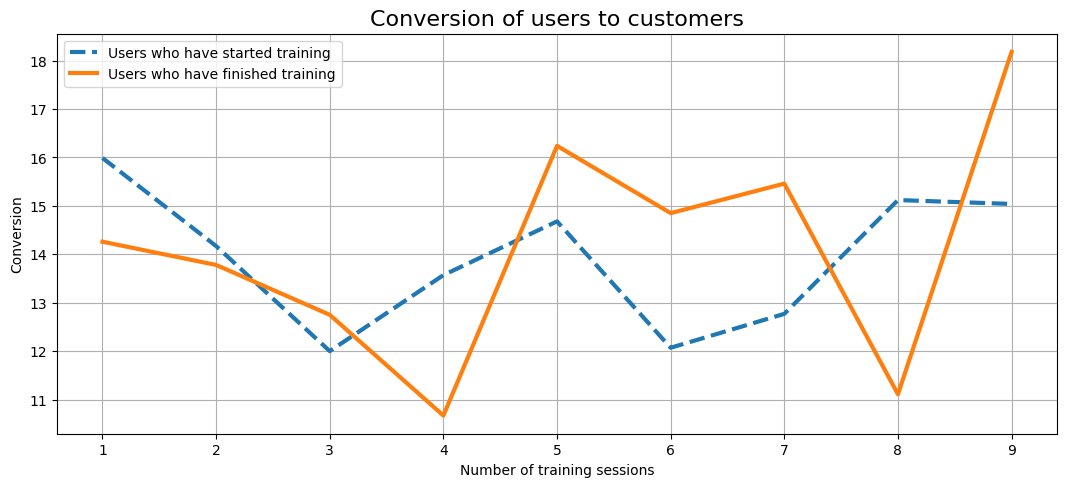

In [34]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(grouped_started_count['conversion'], label='Users who have started training', lw=3,linestyle='dashed')
axes.plot(grouped_finished_count['conversion'], label='Users who have finished training', lw=3)

# Setting display parameters
axes.set_title('Conversion of users to customers', fontsize=16)
axes.set_xlabel('Number of training sessions')
axes.set_ylabel('Conversion')
axes.grid()
axes.legend();

***Conclusions:***
*According to the results of the study, users who have been trained are more likely to convert into customers than users who have not been trained at all. At the same time, the difference is insignificant, whether the training was completed or not. It is possible that users, having started training, go through all its stages, but do not confirm the end of training.
As for the stage at which the user is trained - regardless of at what point and how many times the user is trained - the conversion to purchase is always higher than that of the segment of users who have never started training.*

### 3. Check how transparent the process of interacting with the game is.

In [35]:
# Check how often users return to training after they have chosen a level
tutorial_after_level_df = registration_df.merge(tutorial_df,on=['user_id'], how='right')
tutorial_after_level_df = tutorial_after_level_df.drop(
    columns=['event_id_x','selected_level_x','purchase_id_x','amount_x','event_id_y','purchase_id_y','amount_y']
    )
tutorial_after_level_df = tutorial_after_level_df.merge(level_df,on=['user_id'], how='left')
tutorial_after_level_df = tutorial_after_level_df.drop(
    columns=['tutorial_id_x','selected_level_y','tutorial_id_y','event_id','selected_level','tutorial_id','purchase_id','amount']
    )
tutorial_after_level_df

,event_type_x,registration_time,user_id,event_type_y,tutorial_start_time,event_type,level_time
0,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 14:54:40,NaN,NaT
1,registration,2018-01-01 11:54:47,27835,tutorial_start,2018-01-01 15:00:51,level_choice,2018-01-01 20:37:22
2,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 15:40:43,NaN,NaT
3,registration,2018-01-01 04:07:25,27833,tutorial_start,2018-01-01 17:47:40,NaN,NaT
4,registration,2018-01-01 18:24:01,27839,tutorial_start,2018-01-01 19:11:36,level_choice,2018-01-01 22:37:50
...,...,...,...,...,...,...,...
18045,registration,2018-12-31 03:01:17,47747,tutorial_start,2018-12-31 10:21:11,level_choice,2018-12-31 12:24:40
18046,registration,2018-12-31 13:55:01,47751,tutorial_start,2018-12-31 19:38:14,NaN,NaT
18047,registration,2018-12-31 18:58:55,47753,tutorial_start,2018-12-31 20:54:56,level_choice,2018-12-31 22:36:19
18048,registration,2018-12-31 21:15:14,47755,tutorial_start,2019-01-01 00:08:14,level_choice,2019-01-01 05:04:52


In [36]:
# Calculate the time between the start of training and the choice of level
tutorial_after_level_df['tutorial_level_delta']=tutorial_after_level_df['level_time']-tutorial_after_level_df['tutorial_start_time']
tutorial_after_level_df['tutorial_level_delta']=tutorial_after_level_df['tutorial_level_delta'].fillna(pd.Timedelta(0))
tutorial_after_level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   event_type_x          18050 non-null  object         
 1   registration_time     18050 non-null  datetime64[ns] 
 2   user_id               18050 non-null  int64          
 3   event_type_y          18050 non-null  object         
 4   tutorial_start_time   18050 non-null  datetime64[ns] 
 5   event_type            12686 non-null  object         
 6   level_time            12686 non-null  datetime64[ns] 
 7   tutorial_level_delta  18050 non-null  timedelta64[ns]
dtypes: datetime64[ns](3), int64(1), object(3), timedelta64[ns](1)
memory usage: 1.1+ MB


In [37]:
# Creating a function to count the number of users who have been trained in the level selection field
def add_tutorial_cnt (row):
    if row['tutorial_level_delta']< pd.Timedelta(0):
        return 1
    
tutorial_after_level_df['add_tutorial'] = tutorial_after_level_df.apply(add_tutorial_cnt,axis=1)
tutorial_after_level_df

,event_type_x,registration_time,user_id,event_type_y,tutorial_start_time,event_type,level_time,tutorial_level_delta,add_tutorial
0,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 14:54:40,NaN,NaT,0 days 00:00:00,NaN
1,registration,2018-01-01 11:54:47,27835,tutorial_start,2018-01-01 15:00:51,level_choice,2018-01-01 20:37:22,0 days 05:36:31,NaN
2,registration,2018-01-01 13:28:07,27836,tutorial_start,2018-01-01 15:40:43,NaN,NaT,0 days 00:00:00,NaN
3,registration,2018-01-01 04:07:25,27833,tutorial_start,2018-01-01 17:47:40,NaN,NaT,0 days 00:00:00,NaN
4,registration,2018-01-01 18:24:01,27839,tutorial_start,2018-01-01 19:11:36,level_choice,2018-01-01 22:37:50,0 days 03:26:14,NaN
...,...,...,...,...,...,...,...,...,...
18045,registration,2018-12-31 03:01:17,47747,tutorial_start,2018-12-31 10:21:11,level_choice,2018-12-31 12:24:40,0 days 02:03:29,NaN
18046,registration,2018-12-31 13:55:01,47751,tutorial_start,2018-12-31 19:38:14,NaN,NaT,0 days 00:00:00,NaN
18047,registration,2018-12-31 18:58:55,47753,tutorial_start,2018-12-31 20:54:56,level_choice,2018-12-31 22:36:19,0 days 01:41:23,NaN
18048,registration,2018-12-31 21:15:14,47755,tutorial_start,2019-01-01 00:08:14,level_choice,2019-01-01 05:04:52,0 days 04:56:38,NaN


In [38]:
add_tutorial_df = tutorial_after_level_df[tutorial_after_level_df['add_tutorial']>0]
print('The number of users who started training after choosing the difficulty level:', add_tutorial_df['user_id'].nunique())
percent = (add_tutorial_df['user_id'].nunique()*100/total_events_df['user_id'].nunique())
print('Percentage of users who started training after choosing the level from all registered users:', round(percent, 2))
level_choosed_users = total_events_df[total_events_df['event_type']=='level_choice']
percent2=(add_tutorial_df['user_id'].nunique()*100/level_choosed_users['user_id'].nunique())
print('Percentage of users who started training after choosing the difficulty level, from all users who chose the difficulty level:', round(percent2, 2))

The number of users who started training after choosing the difficulty level: 1386
Percentage of users who started training after choosing the level from all registered users: 6.96
Percentage of users who started training after choosing the difficulty level, from all users who chose the difficulty level: 16.61


***Conclusions:***
*The proportion of users who returned to training after choosing the difficulty level is small. This suggests that the game is quite clear and causes difficulties for only a small part of users. Perhaps these are users who returned to the game after some time and they needed re-training.*